In [1]:
# Standard imports
import pathlib

# Third party imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

# Internal imports

In [2]:
# set plot style
%matplotlib widget
plt.style.use('plot_style.txt')

# output path for figures 
output_path = pathlib.Path("/home/jonas/shared/Work/SSeep2026/Figures")

# set equation colors
c_ex = 'k'
c_dis = "#d65d17ff"
c_max = "#57db2fff"
c_mf = "#14b7ccff"

In [108]:
# load data
df = pd.read_csv('exp4_BCB_SAND/rel_error.csv', index_col=0)

stage = df['stage'].unique()
cl_cond = df['cl_cond'].unique()
cl_th = df['cl_th'].unique()
print(cl_cond)
print(cl_th)

[1.e-08 1.e-06]
[0.1 1. ]


In [111]:
i1 = 1 # thickness
i2 = 0 # conductivity

idx = np.logical_and(df['cl_cond'] == cl_cond[i2], df['cl_th'] == cl_th[i1])
_df = df.loc[idx]
print(f'{cl_th[i1] / cl_cond[i2]:.2e}')

data_dis = [_df.loc[_df['stage'] == v, 'rel_err_max'].values for v in stage]
data_max = [_df.loc[_df['stage'] == v, 'rel_err_dis'].values for v in stage]
data_mf = [_df.loc[_df['stage'] == v, 'rel_err_mf'].values for v in stage]

1.00e+08


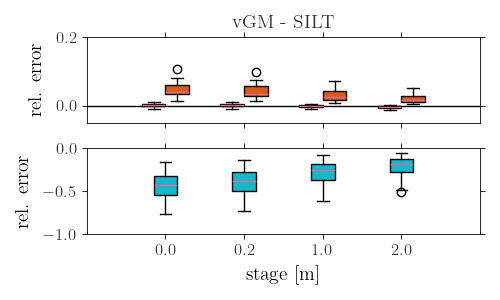

In [112]:
fig, axs = plt.subplots(2, figsize=(5, 3))

x = np.arange(1, 5)
dx = 0.15

bp_dis = axs[0].boxplot(data_dis, positions=x + dx, whis=1.5, widths=0.3, patch_artist=True,)
for patch in bp_dis['boxes']:
    patch.set_facecolor(c_dis)

bp_max = axs[0].boxplot(data_max, positions=x - dx, whis=1.5, widths=0.3, patch_artist=True,)
for patch in bp_max['boxes']:
    patch.set_facecolor(c_max)

axs[0].axhline(0, ls='-', lw=1, c='k')

bp_mf = axs[1].boxplot(data_mf, positions=x, whis=1.5, widths=0.3, patch_artist=True,)
for patch in bp_mf['boxes']:
    patch.set_facecolor(c_mf)

for ax in axs:
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.tick_params(top=True, right=True)
    ax.set(xscale='linear', yscale='linear')
    ax.minorticks_off()
    ax.set_xlim(xmin=0, xmax=5)
    ax.set_xticks(x, labels=[])
    ax.set_ylabel('rel. error', labelpad=8)

axs[0].set_ylim(ymin=-0.05, ymax=0.2)
axs[1].set_ylim(ymin=-1, ymax=0)
axs[1].set_xticklabels(stage)
axs[1].set_xlabel('stage [m]', labelpad=5)
#ax.set_yticks([1, 3, 5], labels=[])
axs[0].set_title(f'vGM - SILT', loc='center', fontsize=14)

plt.tight_layout()
#plt.savefig(output_path / 'rel_error_vGM_SILT.pdf')